In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import keras
%matplotlib inline

In [72]:
df = pd.read_csv('train_E6oV3lV.csv')

In [73]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [74]:
df.groupby('label').count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


In [75]:
count_class_0, count_class_1 = df['label'].value_counts()

In [76]:
df_class_0 =  df.query('label==0')
df_class_1 =  df.query('label==1')

In [77]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1],ignore_index=True ,axis=0)

In [78]:
df_under.shape

(4484, 3)

In [79]:
df_under.groupby('label').count()

,id,tweet
label,,
0,2242,2242
1,2242,2242


In [80]:
X = df_under['tweet']
Y = df_under['label']
Y_org = Y

In [81]:
from keras.preprocessing.text import Tokenizer
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' ', lower=True, char_level=False, oov_token=None)
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)

# add padding
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=400)

In [82]:
max(df['tweet'], key=len)

' @user lmfao pathetic #soit   #growup #funny #noonethere #iknowwhoitis ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98±ð\x9f\x98±ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98±ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82â\x80¦'

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit(X).transform(X)

/home/shivam/.conda/envs/my_root/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 35)
pca.fit(X)
X = pca.transform(X);

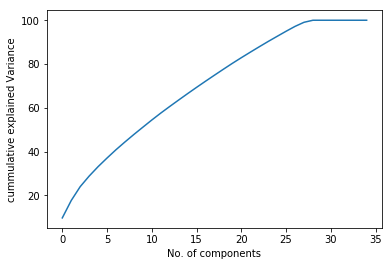

In [85]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [86]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2, random_state= 42)

In [87]:
from keras.models import Sequential 

In [88]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [89]:
classifier = Sequential()
classifier.add(LSTM(units=40, activation='relu',return_sequences= True, input_shape=(None, 35)))
classifier.add(Dropout(rate=0.3))

In [90]:
classifier.add(LSTM(units=20, return_sequences= True,activation='relu'))
classifier.add(Dropout(rate=0.2))
classifier.add(LSTM(units=20,activation='relu'))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(units = 2, activation='sigmoid'))

In [91]:
classifier.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
y_e = OneHotEncoder()
Y_train_org = Y_train
Y_test_org = Y_test
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
y_e.fit(Y_train)
Y_train = y_e.transform(Y_train)
Y_test = y_e.transform(Y_test)

/home/shivam/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/home/shivam/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [ ]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0],1 ,X_test.shape[1]))
import tensorflow as tf
with tf.device('/gpu:0'):
    checker = classifier.fit(X_train_lstm, Y_train, batch_size=32, epochs=200, validation_data = (X_test_lstm, Y_test))


Train on 3587 samples, validate on 897 samples
Epoch 1/200
3587/3587 [==============================] - 4s 1ms/step - loss: 0.6913 - acc: 0.5362 - val_loss: 0.6879 - val_acc: 0.6700
Epoch 2/200
3587/3587 [==============================] - 1s 384us/step - loss: 0.6810 - acc: 0.6694 - val_loss: 0.6718 - val_acc: 0.6767
Epoch 3/200
3587/3587 [==============================] - 2s 423us/step - loss: 0.6652 - acc: 0.6892 - val_loss: 0.6527 - val_acc: 0.6862
Epoch 4/200
3587/3587 [==============================] - 1s 388us/step - loss: 0.6393 - acc: 0.6960 - val_loss: 0.6360 - val_acc: 0.6901
Epoch 5/200
3587/3587 [==============================] - 1s 388us/step - loss: 0.6270 - acc: 0.6991 - val_loss: 0.6273 - val_acc: 0.6890
Epoch 6/200
3587/3587 [==============================] - 1s 389us/step - loss: 0.6194 - acc: 0.7021 - val_loss: 0.6228 - val_acc: 0.6912
Epoch 7/200
3587/3587 [==============================] - 1s 391us/step - loss: 0.6153 - acc: 0.7066 - val_loss: 0.6173 - val_acc: 0.6

3587/3587 [==============================] - 1s 381us/step - loss: 0.5065 - acc: 0.7774 - val_loss: 0.6255 - val_acc: 0.7207
Epoch 61/200
3587/3587 [==============================] - 1s 382us/step - loss: 0.5079 - acc: 0.7781 - val_loss: 0.6243 - val_acc: 0.7179
Epoch 62/200
3587/3587 [==============================] - 1s 380us/step - loss: 0.5071 - acc: 0.7789 - val_loss: 0.6267 - val_acc: 0.7179
Epoch 63/200
3587/3587 [==============================] - 1s 378us/step - loss: 0.5081 - acc: 0.7809 - val_loss: 0.6359 - val_acc: 0.7179
Epoch 64/200
3587/3587 [==============================] - 1s 387us/step - loss: 0.5041 - acc: 0.7810 - val_loss: 0.6315 - val_acc: 0.7174
Epoch 65/200
3587/3587 [==============================] - 1s 387us/step - loss: 0.5073 - acc: 0.7817 - val_loss: 0.6303 - val_acc: 0.7224
Epoch 66/200
3587/3587 [==============================] - 1s 381us/step - loss: 0.5126 - acc: 0.7759 - val_loss: 0.6324 - val_acc: 0.7213
Epoch 67/200
3587/3587 [=======================

3587/3587 [==============================] - 1s 382us/step - loss: 0.4605 - acc: 0.7979 - val_loss: 0.6441 - val_acc: 0.7324
Epoch 120/200
3587/3587 [==============================] - 1s 380us/step - loss: 0.4524 - acc: 0.8067 - val_loss: 0.6531 - val_acc: 0.7280
Epoch 121/200
3587/3587 [==============================] - 1s 383us/step - loss: 0.4488 - acc: 0.8069 - val_loss: 0.6630 - val_acc: 0.7269
Epoch 122/200
3587/3587 [==============================] - 1s 381us/step - loss: 0.4554 - acc: 0.8018 - val_loss: 0.6427 - val_acc: 0.7313
Epoch 123/200
3587/3587 [==============================] - 1s 377us/step - loss: 0.4523 - acc: 0.8085 - val_loss: 0.6513 - val_acc: 0.7347
Epoch 124/200
3587/3587 [==============================] - 1s 383us/step - loss: 0.4484 - acc: 0.8029 - val_loss: 0.6471 - val_acc: 0.7358
Epoch 125/200
3587/3587 [==============================] - 1s 386us/step - loss: 0.4539 - acc: 0.8021 - val_loss: 0.6332 - val_acc: 0.7358
Epoch 126/200
3587/3587 [================

In [ ]:
Y_pred_test_label = classifier.predict(X_test_lstm)
y_pred_test=np.argmax(Y_pred_test_label,axis =1)
y_pred_test
Y_pred_train_label = classifier.predict(X_train_lstm)
y_pred_train = np.argmax(Y_pred_train_label,axis=1)
Y_test_true = Y_test_org.astype(np.int)
Y_train_true = Y_train_org.astype(np.int)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_true,y_pred_test))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
### for softmax function
print("TRAIN:  \n",confusion_matrix(y_pred_train,Y_train_true))
print("\nTest:  \n",confusion_matrix(y_pred_test,Y_test_true))

In [ ]:
print(classification_report(Y_train_true,y_pred_train))